In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [2]:
for f in glob.glob('images/resnet_gan/*.png'):
    os.remove(f)

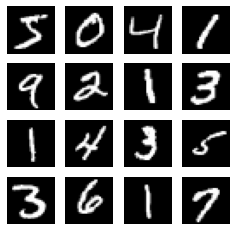

In [3]:
(train_images, train_labels), (validate_images,validate_labels) = tf.keras.datasets.mnist.load_data()
train_images =train_images.reshape([-1,28,28,1]).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

fig = plt.figure(figsize=(4,4))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[i]*127.5+127.5, cmap = 'gray')
    plt.axis('off')
    
BUFFER_SIZE=train_images.shape[0]
BATCH_SIZE=256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
class ResnetUpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filter_size,kernel_size):
        super(ResnetUpSampleBlock, self).__init__(name='')
        
        self.conv2a = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3), strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size, strides=(2,2), 
                                                      padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2DTranspose(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)
    
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.relu(x)
    
class ResnetDownSampleBlock(tf.keras.layers.Layer):
    def __init__(self,filter_size, kernel_size):
        super(ResnetDownSampleBlock, self).__init__(name='')

        self.conv2a = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3), strides=(1,1),
                                             padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filter_size, kernel_size, strides=(2,2), 
                                             padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                             padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2D(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)
        
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.leaky_relu(x)

In [5]:
def make_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((7, 7, 512)))
    assert model.output_shape == (None, 7, 7, 512) 
    model.add(ResnetUpSampleBlock(256,3))
    assert model.output_shape == (None,14,14,256)
    model.add(layers.BatchNormalization())
    model.add(ResnetUpSampleBlock(128,3))
    assert model.output_shape == (None,28,28,128)
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (1, 1), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28 ,28, 1)

    return model


def make_discriminator():
    model = tf.keras.Sequential()
    model.add(ResnetDownSampleBlock(128,3))
    model.add(layers.BatchNormalization())
    model.add(ResnetDownSampleBlock(64,3))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [6]:
latent_dim = 128
generator = make_generator(latent_dim)
discriminator = make_discriminator()

In [7]:
def generator_loss():
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    fake_images = generator(z,training=True)
    fake_output = discriminator(fake_images,training=True)
    g_loss = -tf.reduce_mean(tf.math.log(fake_output))
    return g_loss

def discriminator_loss(real_images):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    fake_images = generator(z,training=True)
    fake_output = discriminator(fake_images,training=True)
    real_output = discriminator(real_images,training=True)
    d_loss_real = tf.reduce_mean(tf.math.log(real_output))
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-fake_output))
    d_loss = d_loss_real+d_loss_fake
    return -d_loss

In [8]:
def save_generator_samples(epoch):
    z = tf.random.normal([16,latent_dim])
    images = tf.reshape(generator(z,training=False),[-1,28,28])
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i]*127.5+127.5, cmap = 'gray')
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig('images/resnet_gan/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

In [9]:
LR = 1e-4
BETA_1 = 0.5
generator_opt = tf.keras.optimizers.Adam(learning_rate=LR,beta_1=BETA_1)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=LR,beta_1=BETA_1)

@tf.function
def train_step(real_images): 
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_loss = generator_loss()
        d_loss = discriminator_loss(real_images)
       
    g_grad = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grad = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(g_grad,generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(d_grad,discriminator.trainable_variables))
    
    return d_loss,g_loss

def train(dataset, epochs):
    t = trange(epochs)
    for epoch in t:
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
            t.set_description("D loss: %0.3f G loss: %0.3f" %(d_loss.numpy(),g_loss.numpy()))
            t.refresh()
        save_generator_samples(epoch)
EPOCHS = 100
train(train_dataset,EPOCHS)

D loss: 0.502 G loss: 1.523: 100%|██████████| 100/100 [31:29<00:00, 18.89s/it]


In [10]:
import glob
import imageio
anim_file = 'resnet_gan_2.gif'

with imageio.get_writer(anim_file, mode='I',fps=1) as writer:
    filenames = glob.glob('images/resnet_gan/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


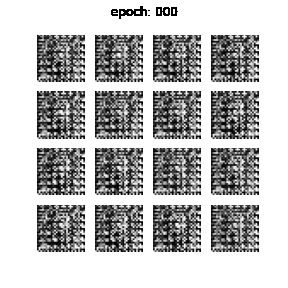

In [12]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [18]:
def plot_samples(model,size):
    z = tf.random.normal([size**2,latent_dim])
    images = tf.reshape(model(z,training=False),[-1,28,28])
    fig = plt.figure(figsize=(7,7))
    for i in range(size**2):
        plt.subplot(size,size,i+1)
        plt.imshow(images[i]*127.5+127.5, cmap = 'gray')
        plt.axis('off')
    plt.show()
    plt.pause(0.05)

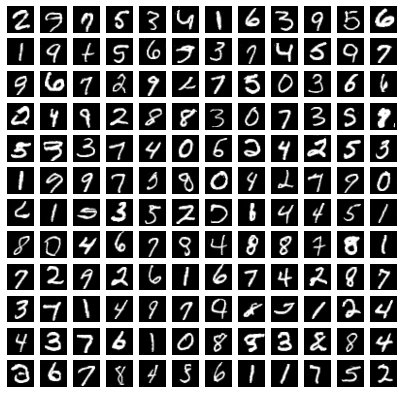

In [19]:
plot_samples(generator,12)

In [20]:
#saving and loading model
generator.compile(generator_opt)
generator.save('models/resnet/generator')

discriminator.compile(discriminator_opt)
discriminator.save('models/resnet/disciminator')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/resnet/generator/assets
INFO:tensorflow:Assets written to: models/resnet/disciminator/assets


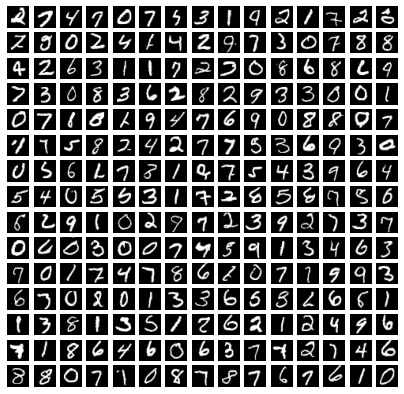

In [21]:
generator_new = tf.keras.models.load_model('models/resnet/generator')
plot_samples(generator_new,15)